In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512) 
        self.fc0 = nn.Linear(512, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [2]:
#torch.manual_seed(7)

In [3]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_57869/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_57869/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [4]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_57869/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_57869/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [5]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [6]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    for i in range(len(lay)):
        if i > 0 and i <= len(lay)-1:
            di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


  0%|          | 0/235 [00:00<?, ?it/s]

100%|██████████| 235/235 [00:01<00:00, 170.21it/s]


Epoch 0/100, Loss: 0.012856663204729557, train dataset accuracy: 85.12333333333333
test dataset accuracy: 93.91%


100%|██████████| 235/235 [00:01<00:00, 195.20it/s]


Epoch 1/100, Loss: 0.011287459172308445, train dataset accuracy: 94.265
test dataset accuracy: 94.87%


100%|██████████| 235/235 [00:01<00:00, 198.60it/s]


Epoch 2/100, Loss: 0.010690336115658283, train dataset accuracy: 94.74
test dataset accuracy: 94.99%


100%|██████████| 235/235 [00:01<00:00, 193.28it/s]


Epoch 3/100, Loss: 0.010673263110220432, train dataset accuracy: 94.945
test dataset accuracy: 94.82%


100%|██████████| 235/235 [00:01<00:00, 195.40it/s]


Epoch 4/100, Loss: 0.006298461463302374, train dataset accuracy: 94.94666666666667
test dataset accuracy: 95.37%


100%|██████████| 235/235 [00:01<00:00, 184.46it/s]


Epoch 5/100, Loss: 0.00789364892989397, train dataset accuracy: 94.96833333333333
test dataset accuracy: 95.17%


100%|██████████| 235/235 [00:01<00:00, 190.64it/s]


Epoch 6/100, Loss: 0.004325853195041418, train dataset accuracy: 95.01666666666667
test dataset accuracy: 94.74%


100%|██████████| 235/235 [00:01<00:00, 194.68it/s]


Epoch 7/100, Loss: 0.008842124603688717, train dataset accuracy: 94.82166666666667
test dataset accuracy: 94.48%


100%|██████████| 235/235 [00:01<00:00, 182.84it/s]


Epoch 8/100, Loss: 0.006487214472144842, train dataset accuracy: 94.875
test dataset accuracy: 94.68%


100%|██████████| 235/235 [00:01<00:00, 193.06it/s]


Epoch 9/100, Loss: 0.008496141992509365, train dataset accuracy: 94.99666666666667
test dataset accuracy: 94.89%


100%|██████████| 235/235 [00:01<00:00, 193.33it/s]


Epoch 10/100, Loss: 0.003863754915073514, train dataset accuracy: 95.1
test dataset accuracy: 95.37%


100%|██████████| 235/235 [00:01<00:00, 195.99it/s]


Epoch 11/100, Loss: 0.006090824492275715, train dataset accuracy: 95.06166666666667
test dataset accuracy: 95.0%


100%|██████████| 235/235 [00:01<00:00, 187.50it/s]


Epoch 12/100, Loss: 0.00630682660266757, train dataset accuracy: 94.72833333333334
test dataset accuracy: 95.07%


100%|██████████| 235/235 [00:01<00:00, 188.51it/s]


Epoch 13/100, Loss: 0.006726066581904888, train dataset accuracy: 94.82666666666667
test dataset accuracy: 94.6%


100%|██████████| 235/235 [00:01<00:00, 196.30it/s]


Epoch 14/100, Loss: 0.012495114468038082, train dataset accuracy: 94.785
test dataset accuracy: 94.45%


100%|██████████| 235/235 [00:01<00:00, 188.24it/s]


Epoch 15/100, Loss: 0.010232312604784966, train dataset accuracy: 95.14666666666666
test dataset accuracy: 94.92%


100%|██████████| 235/235 [00:01<00:00, 192.89it/s]


Epoch 16/100, Loss: 0.007963782176375389, train dataset accuracy: 95.33
test dataset accuracy: 95.16%


100%|██████████| 235/235 [00:01<00:00, 197.66it/s]


Epoch 17/100, Loss: 0.012471972964704037, train dataset accuracy: 95.45
test dataset accuracy: 92.69%


100%|██████████| 235/235 [00:01<00:00, 194.78it/s]


Epoch 18/100, Loss: 0.00988793559372425, train dataset accuracy: 95.31166666666667
test dataset accuracy: 94.95%


100%|██████████| 235/235 [00:01<00:00, 189.82it/s]


Epoch 19/100, Loss: 0.00722387945279479, train dataset accuracy: 95.515
test dataset accuracy: 94.64%


100%|██████████| 235/235 [00:01<00:00, 192.52it/s]


Epoch 20/100, Loss: 0.007296897005289793, train dataset accuracy: 95.44666666666667
test dataset accuracy: 95.11%


100%|██████████| 235/235 [00:01<00:00, 196.60it/s]


Epoch 21/100, Loss: 0.011965999379754066, train dataset accuracy: 95.665
test dataset accuracy: 94.27%


100%|██████████| 235/235 [00:01<00:00, 183.81it/s]


Epoch 22/100, Loss: 0.01613600179553032, train dataset accuracy: 95.63
test dataset accuracy: 94.96%


100%|██████████| 235/235 [00:01<00:00, 192.97it/s]


Epoch 23/100, Loss: 0.00878863874822855, train dataset accuracy: 95.10166666666667
test dataset accuracy: 94.82%


100%|██████████| 235/235 [00:01<00:00, 188.36it/s]


Epoch 24/100, Loss: 0.009080972522497177, train dataset accuracy: 95.44166666666666
test dataset accuracy: 95.26%


100%|██████████| 235/235 [00:01<00:00, 184.55it/s]


Epoch 25/100, Loss: 0.010999816469848156, train dataset accuracy: 95.61333333333333
test dataset accuracy: 95.32%


100%|██████████| 235/235 [00:01<00:00, 188.10it/s]


Epoch 26/100, Loss: 0.006380701903253794, train dataset accuracy: 95.77666666666667
test dataset accuracy: 95.42%


100%|██████████| 235/235 [00:01<00:00, 191.19it/s]


Epoch 27/100, Loss: 0.0034264400601387024, train dataset accuracy: 95.385
test dataset accuracy: 95.44%


100%|██████████| 235/235 [00:01<00:00, 190.90it/s]


Epoch 28/100, Loss: 0.00293417158536613, train dataset accuracy: 95.63333333333334
test dataset accuracy: 95.78%


100%|██████████| 235/235 [00:01<00:00, 183.71it/s]


Epoch 29/100, Loss: 0.0059493957087397575, train dataset accuracy: 95.52
test dataset accuracy: 95.2%


100%|██████████| 235/235 [00:01<00:00, 179.17it/s]


Epoch 30/100, Loss: 0.004614477511495352, train dataset accuracy: 95.60666666666667
test dataset accuracy: 95.35%


100%|██████████| 235/235 [00:01<00:00, 145.45it/s]


Epoch 31/100, Loss: 0.0014081429690122604, train dataset accuracy: 95.68833333333333
test dataset accuracy: 95.04%


100%|██████████| 235/235 [00:01<00:00, 185.02it/s]


Epoch 32/100, Loss: 0.006466442719101906, train dataset accuracy: 95.56
test dataset accuracy: 95.37%


100%|██████████| 235/235 [00:01<00:00, 198.52it/s]


Epoch 33/100, Loss: 0.005198806058615446, train dataset accuracy: 95.67166666666667
test dataset accuracy: 95.72%


100%|██████████| 235/235 [00:01<00:00, 188.14it/s]


Epoch 34/100, Loss: 0.015406360849738121, train dataset accuracy: 95.545
test dataset accuracy: 95.44%


100%|██████████| 235/235 [00:01<00:00, 192.39it/s]


Epoch 35/100, Loss: 0.008430306799709797, train dataset accuracy: 95.65166666666667
test dataset accuracy: 95.22%


100%|██████████| 235/235 [00:01<00:00, 191.87it/s]


Epoch 36/100, Loss: 0.0037132292054593563, train dataset accuracy: 95.03166666666667
test dataset accuracy: 94.91%


100%|██████████| 235/235 [00:01<00:00, 189.35it/s]


Epoch 37/100, Loss: 0.00446021743118763, train dataset accuracy: 94.915
test dataset accuracy: 95.61%


100%|██████████| 235/235 [00:01<00:00, 192.93it/s]


Epoch 38/100, Loss: 0.006667954381555319, train dataset accuracy: 95.96833333333333
test dataset accuracy: 96.03%


100%|██████████| 235/235 [00:01<00:00, 183.91it/s]


Epoch 39/100, Loss: 0.006246363744139671, train dataset accuracy: 96.04666666666667
test dataset accuracy: 95.82%


100%|██████████| 235/235 [00:01<00:00, 196.51it/s]


Epoch 40/100, Loss: 0.005017778370529413, train dataset accuracy: 96.15166666666667
test dataset accuracy: 95.64%


100%|██████████| 235/235 [00:01<00:00, 196.46it/s]


Epoch 41/100, Loss: 0.00809120200574398, train dataset accuracy: 95.63833333333334
test dataset accuracy: 96.01%


100%|██████████| 235/235 [00:01<00:00, 189.30it/s]


Epoch 42/100, Loss: 0.00247206655330956, train dataset accuracy: 96.225
test dataset accuracy: 95.64%


100%|██████████| 235/235 [00:01<00:00, 194.23it/s]


Epoch 43/100, Loss: 0.0051162284798920155, train dataset accuracy: 96.08
test dataset accuracy: 95.91%


100%|██████████| 235/235 [00:01<00:00, 185.87it/s]


Epoch 44/100, Loss: 0.014973324723541737, train dataset accuracy: 95.12833333333333
test dataset accuracy: 92.67%


100%|██████████| 235/235 [00:01<00:00, 191.20it/s]


Epoch 45/100, Loss: 0.005801753140985966, train dataset accuracy: 94.16166666666666
test dataset accuracy: 95.56%


100%|██████████| 235/235 [00:01<00:00, 179.57it/s]


Epoch 46/100, Loss: 0.004686628468334675, train dataset accuracy: 95.93166666666667
test dataset accuracy: 94.77%


100%|██████████| 235/235 [00:01<00:00, 185.10it/s]


Epoch 47/100, Loss: 0.006833272520452738, train dataset accuracy: 95.99166666666666
test dataset accuracy: 94.68%


100%|██████████| 235/235 [00:01<00:00, 168.02it/s]


Epoch 48/100, Loss: 0.009248176589608192, train dataset accuracy: 96.03166666666667
test dataset accuracy: 95.53%


100%|██████████| 235/235 [00:01<00:00, 182.99it/s]


Epoch 49/100, Loss: 0.006370925810188055, train dataset accuracy: 95.98833333333333
test dataset accuracy: 95.59%


100%|██████████| 235/235 [00:01<00:00, 193.01it/s]


Epoch 50/100, Loss: 0.007350076921284199, train dataset accuracy: 96.00166666666667
test dataset accuracy: 95.78%


100%|██████████| 235/235 [00:01<00:00, 198.79it/s]


Epoch 51/100, Loss: 0.0066300430335104465, train dataset accuracy: 96.195
test dataset accuracy: 95.92%


100%|██████████| 235/235 [00:01<00:00, 195.50it/s]


Epoch 52/100, Loss: 0.0052223773673176765, train dataset accuracy: 96.27666666666667
test dataset accuracy: 95.79%


100%|██████████| 235/235 [00:01<00:00, 198.89it/s]


Epoch 53/100, Loss: 0.006305471528321505, train dataset accuracy: 95.26833333333333
test dataset accuracy: 94.69%


100%|██████████| 235/235 [00:01<00:00, 198.50it/s]


Epoch 54/100, Loss: 0.002606353722512722, train dataset accuracy: 96.105
test dataset accuracy: 95.75%


100%|██████████| 235/235 [00:01<00:00, 200.72it/s]


Epoch 55/100, Loss: 0.004535222426056862, train dataset accuracy: 96.245
test dataset accuracy: 95.47%


100%|██████████| 235/235 [00:01<00:00, 189.87it/s]


Epoch 56/100, Loss: 0.016075871884822845, train dataset accuracy: 90.165
test dataset accuracy: 83.36%


100%|██████████| 235/235 [00:01<00:00, 188.78it/s]


Epoch 57/100, Loss: 0.013716990128159523, train dataset accuracy: 91.42833333333333
test dataset accuracy: 93.12%


100%|██████████| 235/235 [00:01<00:00, 197.23it/s]


Epoch 58/100, Loss: 0.01775074005126953, train dataset accuracy: 93.53
test dataset accuracy: 92.26%


100%|██████████| 235/235 [00:01<00:00, 188.72it/s]


Epoch 59/100, Loss: 0.019416995346546173, train dataset accuracy: 94.18833333333333
test dataset accuracy: 94.51%


100%|██████████| 235/235 [00:01<00:00, 200.76it/s]


Epoch 60/100, Loss: 0.010771230794489384, train dataset accuracy: 94.90333333333334
test dataset accuracy: 91.76%


100%|██████████| 235/235 [00:01<00:00, 192.97it/s]


Epoch 61/100, Loss: 0.012341207824647427, train dataset accuracy: 94.95166666666667
test dataset accuracy: 94.79%


100%|██████████| 235/235 [00:01<00:00, 195.55it/s]


Epoch 62/100, Loss: 0.009733024053275585, train dataset accuracy: 95.345
test dataset accuracy: 95.4%


100%|██████████| 235/235 [00:01<00:00, 187.42it/s]


Epoch 63/100, Loss: 0.0068573132157325745, train dataset accuracy: 95.78
test dataset accuracy: 95.34%


100%|██████████| 235/235 [00:01<00:00, 201.45it/s]


Epoch 64/100, Loss: 0.00905470922589302, train dataset accuracy: 95.62
test dataset accuracy: 95.48%


100%|██████████| 235/235 [00:01<00:00, 195.32it/s]


Epoch 65/100, Loss: 0.007176107261329889, train dataset accuracy: 96.09166666666667
test dataset accuracy: 95.6%


100%|██████████| 235/235 [00:01<00:00, 177.51it/s]


Epoch 66/100, Loss: 0.012520922347903252, train dataset accuracy: 95.05833333333334
test dataset accuracy: 95.59%


100%|██████████| 235/235 [00:01<00:00, 193.26it/s]


Epoch 67/100, Loss: 0.006398434285074472, train dataset accuracy: 95.73833333333333
test dataset accuracy: 95.28%


100%|██████████| 235/235 [00:01<00:00, 196.25it/s]


Epoch 68/100, Loss: 0.017756300047039986, train dataset accuracy: 95.66
test dataset accuracy: 95.28%


100%|██████████| 235/235 [00:01<00:00, 189.07it/s]


Epoch 69/100, Loss: 0.015598410740494728, train dataset accuracy: 95.29166666666667
test dataset accuracy: 93.85%


100%|██████████| 235/235 [00:01<00:00, 180.44it/s]


Epoch 70/100, Loss: 0.006010809913277626, train dataset accuracy: 95.14
test dataset accuracy: 94.61%


100%|██████████| 235/235 [00:01<00:00, 186.91it/s]


Epoch 71/100, Loss: 0.0044235484674572945, train dataset accuracy: 95.74
test dataset accuracy: 94.67%


100%|██████████| 235/235 [00:01<00:00, 191.13it/s]


Epoch 72/100, Loss: 0.008142183534801006, train dataset accuracy: 95.99833333333333
test dataset accuracy: 95.67%


100%|██████████| 235/235 [00:01<00:00, 182.54it/s]


Epoch 73/100, Loss: 0.0131081473082304, train dataset accuracy: 94.36333333333333
test dataset accuracy: 94.55%


100%|██████████| 235/235 [00:01<00:00, 192.52it/s]


Epoch 74/100, Loss: 0.004876732360571623, train dataset accuracy: 95.77666666666667
test dataset accuracy: 95.45%


100%|██████████| 235/235 [00:01<00:00, 195.22it/s]


Epoch 75/100, Loss: 0.011160856112837791, train dataset accuracy: 94.60333333333334
test dataset accuracy: 94.7%


100%|██████████| 235/235 [00:01<00:00, 176.98it/s]


Epoch 76/100, Loss: 0.011305342428386211, train dataset accuracy: 95.26833333333333
test dataset accuracy: 94.67%


100%|██████████| 235/235 [00:01<00:00, 192.15it/s]


Epoch 77/100, Loss: 0.005501443985849619, train dataset accuracy: 95.28166666666667
test dataset accuracy: 95.28%


100%|██████████| 235/235 [00:01<00:00, 180.65it/s]


Epoch 78/100, Loss: 0.009926502592861652, train dataset accuracy: 94.875
test dataset accuracy: 92.16%


100%|██████████| 235/235 [00:01<00:00, 175.23it/s]


Epoch 79/100, Loss: 0.009548489935696125, train dataset accuracy: 95.09666666666666
test dataset accuracy: 95.48%


100%|██████████| 235/235 [00:01<00:00, 169.90it/s]


Epoch 80/100, Loss: 0.005586428102105856, train dataset accuracy: 95.525
test dataset accuracy: 95.45%


100%|██████████| 235/235 [00:01<00:00, 175.68it/s]


Epoch 81/100, Loss: 0.0018892708467319608, train dataset accuracy: 96.16833333333334
test dataset accuracy: 95.7%


100%|██████████| 235/235 [00:01<00:00, 179.46it/s]


Epoch 82/100, Loss: 0.003065443132072687, train dataset accuracy: 96.03166666666667
test dataset accuracy: 95.14%


100%|██████████| 235/235 [00:01<00:00, 185.35it/s]


Epoch 83/100, Loss: 0.011433173902332783, train dataset accuracy: 95.57833333333333
test dataset accuracy: 95.48%


100%|██████████| 235/235 [00:01<00:00, 189.84it/s]


Epoch 84/100, Loss: 0.007247565779834986, train dataset accuracy: 95.17666666666666
test dataset accuracy: 95.18%


100%|██████████| 235/235 [00:01<00:00, 189.12it/s]


Epoch 85/100, Loss: 0.0031633416656404734, train dataset accuracy: 95.83
test dataset accuracy: 95.32%


100%|██████████| 235/235 [00:01<00:00, 190.87it/s]


Epoch 86/100, Loss: 0.0015826249727979302, train dataset accuracy: 96.325
test dataset accuracy: 96.08%


100%|██████████| 235/235 [00:01<00:00, 185.23it/s]


Epoch 87/100, Loss: 0.010965955443680286, train dataset accuracy: 96.75333333333333
test dataset accuracy: 95.87%


100%|██████████| 235/235 [00:01<00:00, 175.70it/s]


Epoch 88/100, Loss: 0.014059516601264477, train dataset accuracy: 96.65833333333333
test dataset accuracy: 95.33%


100%|██████████| 235/235 [00:01<00:00, 177.04it/s]


Epoch 89/100, Loss: 0.011725465767085552, train dataset accuracy: 96.55666666666667
test dataset accuracy: 95.9%


100%|██████████| 235/235 [00:01<00:00, 189.25it/s]


Epoch 90/100, Loss: 0.00987333059310913, train dataset accuracy: 95.57833333333333
test dataset accuracy: 93.87%


100%|██████████| 235/235 [00:01<00:00, 196.17it/s]


Epoch 91/100, Loss: 0.004652490373700857, train dataset accuracy: 95.93166666666667
test dataset accuracy: 95.67%


100%|██████████| 235/235 [00:01<00:00, 194.95it/s]


Epoch 92/100, Loss: 0.014718529768288136, train dataset accuracy: 95.73
test dataset accuracy: 94.78%


100%|██████████| 235/235 [00:01<00:00, 165.17it/s]


Epoch 93/100, Loss: 0.003686080453917384, train dataset accuracy: 95.925
test dataset accuracy: 95.62%


100%|██████████| 235/235 [00:01<00:00, 175.35it/s]


Epoch 94/100, Loss: 0.009546251967549324, train dataset accuracy: 96.61833333333334
test dataset accuracy: 96.07%


100%|██████████| 235/235 [00:01<00:00, 180.69it/s]


Epoch 95/100, Loss: 0.006376214791089296, train dataset accuracy: 96.76666666666667
test dataset accuracy: 96.07%


100%|██████████| 235/235 [00:01<00:00, 174.77it/s]


Epoch 96/100, Loss: 0.010563736781477928, train dataset accuracy: 95.61333333333333
test dataset accuracy: 95.26%


100%|██████████| 235/235 [00:01<00:00, 170.18it/s]


Epoch 97/100, Loss: 0.006979765836149454, train dataset accuracy: 94.46
test dataset accuracy: 94.26%


100%|██████████| 235/235 [00:01<00:00, 182.20it/s]


Epoch 98/100, Loss: 0.026008136570453644, train dataset accuracy: 92.47333333333333
test dataset accuracy: 89.27%


100%|██████████| 235/235 [00:01<00:00, 170.50it/s]


Epoch 99/100, Loss: 0.010433131828904152, train dataset accuracy: 92.60166666666667
test dataset accuracy: 93.7%


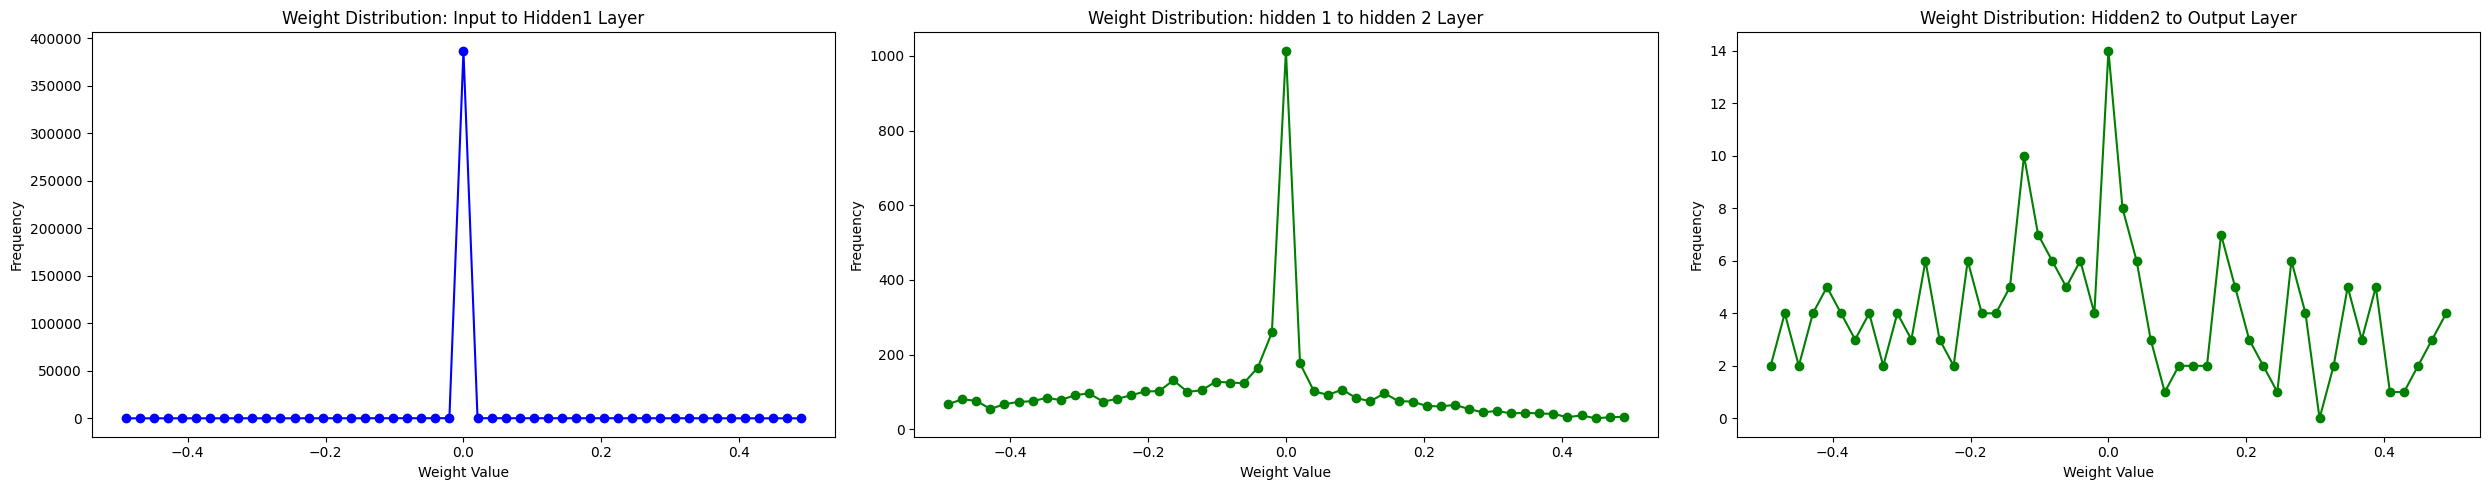

In [12]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [13]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 14488
Number of non-zero weights greater than 0.01 in layer 1: 7181
Number of non-zero weights greater than 0.01 in layer 3: 626


In [14]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.9757300025409273, 0.9755296814475954, 0.9751834431802341, 0.9757599632735816, 0.9750314185859098, 0.9763935158493928, 0.9761624661840291, 0.97622509239955, 0.9757783263397274, 0.9748446075168437, 0.9758563724512432, 0.9762005771337982, 0.9750889905458149, 0.9757540356559226, 0.9762413794058687, 0.975482902933996, 0.9749741336824305, 0.9764621620157617, 0.9752669425547449, 0.974868516667712, 0.9758365718594965, 0.9763399073393433, 0.9753473938872131, 0.9763221889432578, 0.9754143315410935, 0.975484790233107, 0.9764975906574898, 0.9761974497541063, 0.9758828091228794, 0.9758739972143784, 0.9756156391290961, 0.9758375114900557, 0.975305970330038, 0.9759696790967834, 0.9758242086415387, 0.9756324330709046, 0.9764118406574076, 0.976760351739537, 0.9761821139678459, 0.9757352112049688, 0.9752598195749559, 0.9756680441618184, 0.9753103568697108, 0.9762511125891057, 0.9763614117762409, 0.9755125377814287, 0.9760827590367931, 0.9755382828913178, 0.97617858055568, 0.9758291348199645, 0.975233

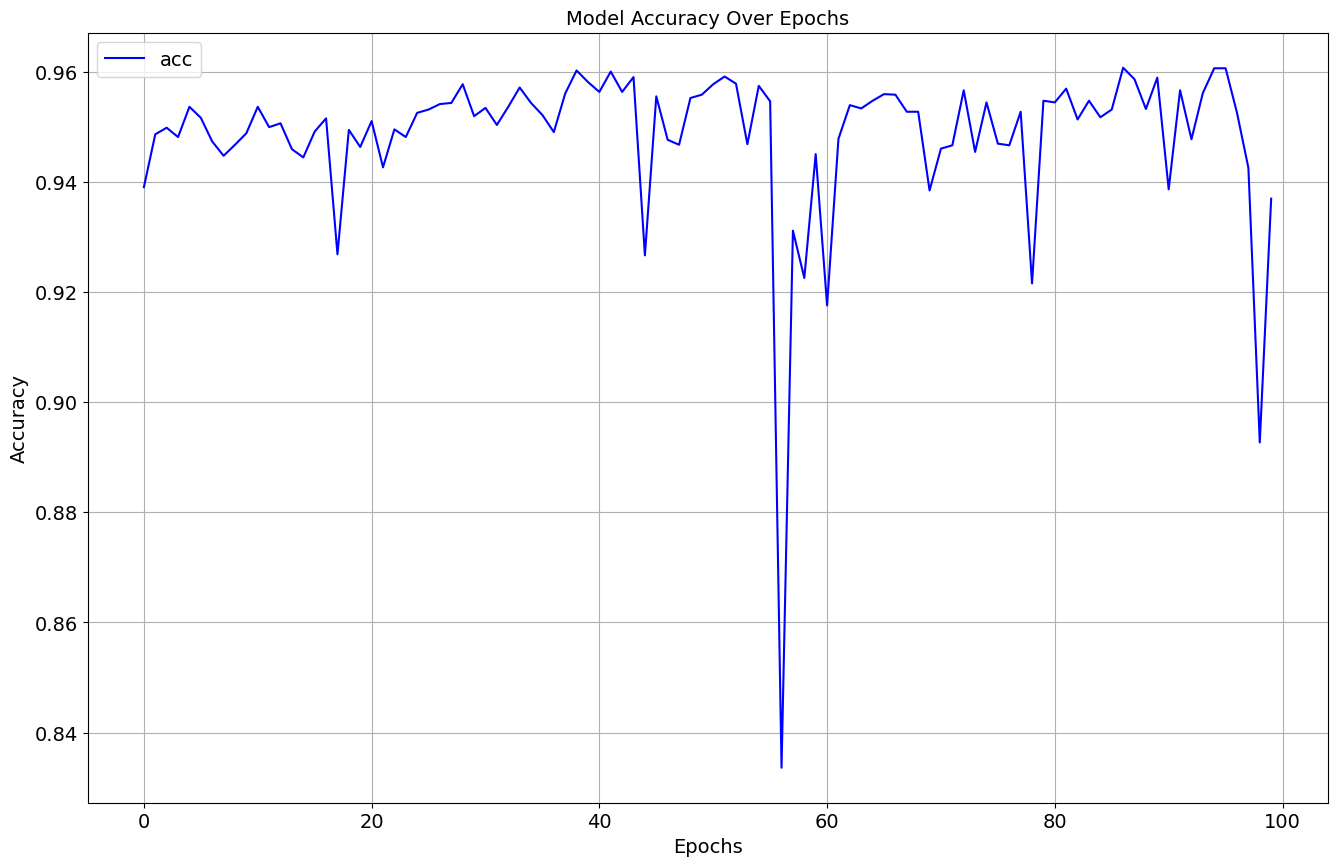

In [15]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [16]:
import pickle
with open('nbOnlineEveryEpochAcc.pkl', 'wb') as f:
    pickle.dump(acc, f)